# Anomaly Dataset Analysis
## loading anomaly data and create normal patch

In [6]:
main_data_dir = r"Z:\CommonModule\classifierTraning\Database\training datasets\data\data\new_dataset\anomaly_detection"
main_save_dir = r"Z:\Open-mmlab\mmclassification-test\data\AnomalyDatasetNewReal"
json_param_path = r"Z:\Open-mmlab\mmclassification-test\data-generator\default_pipeline_params.json"
label_str = ["normal","anomaly"]

g_patch_size = 128 # need to connect json param  

In [ ]:
import os
import cv2

import pandas as pd
from typing import List

from training_data_builder import TrainingPatch , process_dataset, get_datapaths

def load_anomaly_database() -> pd.DataFrame :
    training_patches = []
    empty_patches = []
    small_components_patches = []

    filter_anomalies_labels = ["Board cutting"]

    for datapath in get_datapaths(main_data_dir):
        training_patches_sample, empty_patches_sample, components_patches_sample = process_dataset(
            (datapath, g_patch_size, filter_anomalies_labels, json_param_path)
        )
        training_patches.extend(training_patches_sample)
        empty_patches.extend(empty_patches_sample)
        small_components_patches.extend(components_patches_sample)


    # data_files_suffix = "edge_reflection_included_hs01_included_bottom_images_fixed_paths_additional_components"
    data_files_suffix = "new_dataset_generate"

    all_empty_df = pd.DataFrame(list(map(lambda p: p.to_dict(), empty_patches)))
    all_small_components_df = pd.DataFrame(list(map(lambda p: p.to_dict(), small_components_patches)))

    df = pd.DataFrame(list(map(lambda p: p.to_dict(), training_patches)))

    anomaly_types_distribution = pd.Series(
        list(map(lambda p: p.contour.anomaly_type, training_patches))
    ).value_counts()

    label_distribution = pd.Series(
        list(map(lambda p: p.label, training_patches))
    ).value_counts()
    
    print(f"Loaded {len(training_patches)} patches.")
    print(f"Anomalies types in training patches:\n{anomaly_types_distribution}")
    print(f"Anomalies labels in training patches:\n{label_distribution}")

    return df

analysis_database = load_anomaly_database() 


In [ ]:
from training_data_builder import load_image_and_crop_from_df

dfte = analysis_database
image = load_image_and_crop_from_df(dfte.loc[0])

from matplotlib import pyplot as plt
plt.imshow(image)

## load_csv_data

In [10]:
import pandas as pd

original_file_path = "Z:/Open-mmlab/mmclassification-test/all_training_and_testing_dataset_new_dataset_hs_and_ju2_generate.csv"
file_path = "Z:/Open-mmlab/mmclassification-test/all_training_and_testing_dataset_new_dataset_hs_and_ju2_generate_analysis.csv"

def load_csv_database() -> pd.DataFrame:
    data = pd.read_csv(file_path)
    return data
analysis_database = load_csv_database()

## Utils Test

In [2]:
import re 

def convert_string_to_list(string :str, pattern : str = '[(|,|)| ]') -> list : 
    splitlist = re.split(pattern, string)
    result = [ int(i) for i in splitlist if i != '' ]
    return result 

dfte = analysis_database
result = convert_string_to_list(dfte.loc[0].anomaly_bbox)

print('result : ', result)
print('result type : ', type(result))

print('append : ', result[2])
print('append type : ' , type(result[2]))

print('곱셈테스트 : ', result[2]*result[3] )

result = convert_string_to_list(dfte.loc[0].anomaly_bbox)


result :  [502, 273, 7, 9]
result type :  <class 'list'>
append :  7
append type :  <class 'int'>
곱셈테스트 :  63


In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

def get_anomaly_data_frame(df: pd.DataFrame) -> pd.DataFrame:
    result_df = df[:][df.anomaly_category != 'normal']
    return result_df

def split_data_frame(df: pd.DataFrame) -> dict:
    UniqueLabels = df.anomaly_category.unique()
    DataFrameDict = {elem : pd.DataFrame() for elem in UniqueLabels}
    for key in DataFrameDict.keys():
        DataFrameDict[key] = df[:][df.anomaly_category == key]
    return DataFrameDict

def count_and_plot_bar(df: pd.DataFrame):
    plt.figure(facecolor='#1cc4af')
    countLabel = pd.value_counts(df['anomaly_category'].values, sort=True)
    ax = countLabel.plot.bar(grid=True, fontsize=15)
    plt.show()

def draw_histo_subplot(data:list, title:str, minval = 0, maxval = 0, step = 1):
    if maxval == 0 : 
        maxval = max(data) + step
    
    plt.title(title, fontdict = {'fontsize' : 18})
    plt.hist(data, bins=range(minval, maxval, step)) #bins = [,,,,]

def draw_histo(data:list, title:str, minval = 0, maxval = 0, step = 1):
    if maxval == 0 : 
        maxval = max(data) + step
    
    plt.figure(facecolor='gray')
    plt.grid()
    plt.title(title, fontdict = {'fontsize' : 18})
    plt.hist(data, bins=range(minval, maxval, step)) #bins = [,,,,]
    plt.show()

def get_width_data(df: pd.DataFrame) -> list :
    histo_data = []
    for i in df.index:
        bbox = convert_string_to_list(df.loc[i].anomaly_bbox)
        histo_data.append(bbox[2]) 
    return histo_data

def get_height_data(df: pd.DataFrame) -> list :
    histo_data = []
    for i in df.index:
        bbox = convert_string_to_list(df.loc[i].anomaly_bbox)
        histo_data.append(bbox[3]) 
    return histo_data

def get_size_data(df: pd.DataFrame) -> list :
    histo_data = []
    for i in df.index:
        bbox = convert_string_to_list(df.loc[i].anomaly_bbox)
        histo_data.append(bbox[2] * bbox[3]) 
    return histo_data

def calculate_edge_data(df: pd.DataFrame) -> list :
    data = []
    for i in df.index:
        image = load_image_and_crop_from_df(df.loc[i])
        b,g,r = cv2.split(image)
        edge_b = cv2.Laplacian(b, -1)
        edge_g = cv2.Laplacian(g, -1)
        edge_r = cv2.Laplacian(r, -1)
        data.append(int(edge_b.mean()+edge_g.mean()+edge_r.mean()+0.5)) # 반올림, float은 에러나는데 이유 못찾음 
    return data

def get_list_data(df: pd.DataFrame, colum : str) -> list :
    histo_data = []
    histo_data = list(df[colum])
    #histo_data = convert_string_to_list(histo_data)
    return histo_data

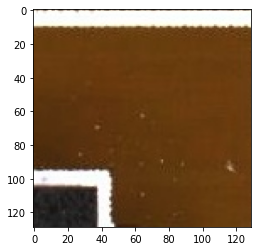

In [11]:
import random 
import numpy as np
from matplotlib import pyplot as plt
import cv2

def load_image_and_crop_from_df(df: pd.DataFrame, opt = 'patch_size') -> np.array:
    image = cv2.imread(df['image_path']) 
    
    annomaly_bbox = []
    patch_bbox = []

    if type(df.anomaly_bbox) is str:
        annomaly_bbox = convert_string_to_list(df.anomaly_bbox)
    else:
        annomaly_bbox = df.anomaly_bbox

    if type(df.bbox) is str:
        patch_bbox = convert_string_to_list(df.bbox)
    else:
        patch_bbox = df.bbox

    if opt == 'real_size' :
        bbox = annomaly_bbox 

        if 0 == df.label :  # 0 is normal 
            targetW = random.randint(3, bbox[2]) 
            targetH = random.randint(3, bbox[3])
            yoffset = random.randint(0, bbox[3] - targetH)
            xoffset = random.randint(0, bbox[2] - targetW)
            temp = list(bbox)
            temp[0] = temp[0] + xoffset
            temp[1] = temp[1] + yoffset
            temp[2] = targetW
            temp[3] = targetH
            bbox = tuple(temp)
    else :
        bbox = patch_bbox #['new_bbox'] # df['anomaly_bbox']

    image = image[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2], :]
    
    return image

dfte = analysis_database
image = load_image_and_crop_from_df(dfte.loc[0])

plt.imshow(image)

In [5]:
import skimage.feature as imageproc
import cv2
    
DataFrameDict = split_data_frame(analysis_database)
dfte = DataFrameDict['Burn']
data = calculate_edge_data(dfte)
print(data)
draw_histo(data, 'laplacian edge(average r,g,b)')


KeyError: 'Burn'

## GetSampleImage and Visualize

In [6]:
import warnings
warnings.filterwarnings(action='ignore')

ColumName = 'laplacian_edge_average'

def get_sample(df: pd.DataFrame, min:int, max:int) -> dict:
    UniqueLabels = df.anomaly_category.unique()
    ResultDict = split_data_frame(df)
    for key in ResultDict.keys():
        ResultDict[key] = ResultDict[key].loc[ResultDict[key][ColumName].isin(range(min,max))]
        ResultDict[key] = ResultDict[key].sort_values(by=[ColumName]) # or uses option : inplace=True 
    return ResultDict

max_count = 10
search_range = range(10,100,10)
for th in search_range:
    test_df = get_sample(analysis_database, max=th, min=th-min(search_range)) 
    plt.figure(facecolor='#1cc4af', figsize=(30,35))
    plt.suptitle('laplacian threshold : '+ str(th), fontsize = 30 , y=0.93) #y가 바닥부터 올라옴
    i = 1
    num_categories = len(test_df.keys())
    for key in test_df.keys():
        j = 1
        for k in test_df[key].index:  
            image = load_image_and_crop_from_df(test_df[key].loc[k])
            plt.subplot(num_categories,max_count,(i-1)*max_count+j) # y : num_categories , x : max_count
            plt.title(key+' values:'+str(test_df[key].loc[k][ColumName]))
            plt.subplots_adjust(wspace=0.15, hspace=0.4, left=0.1, right=0.9)
            plt.imshow(image)
            j=j+1

            if j > max_count:
                break
        i = i+1
    plt.savefig('laplacian_edge_average_'+str(th)+'_sample_image.png')

KeyError: 'laplacian_edge_average'

## count the data each labels

In [7]:
def draw_all_kind_of_histogram(df: pd.DataFrame, title:str) :
    fig = plt.figure(facecolor='#1cc4af', figsize = (40, 10)) 
    plt.suptitle(title, fontsize=30)
    
    plt.grid()
    
    plt.subplot(2,2,1)
    data = get_width_data(df)
    draw_histo_subplot(data, 'width')
    
    plt.subplot(2,2,2)  
    data = get_height_data(df)
    draw_histo_subplot(data, 'height') 

    plt.subplot(2,2,3)
    data = get_size_data(df)
    draw_histo_subplot(data, 'size w x h', maxval=30000, step=100) # step = 100

    plt.subplot(2,2,4)
    data = get_list_data(df, 'laplacian_edge_average')
    draw_histo_subplot(data, 'laplacian edge(average r,g,b)') 
    
    plt.subplots_adjust(wspace=0.07) # left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2
    plt.show()

draw_all_kind_of_histogram(DataFrameDict['Burn'], 'Burn - tatol:num:'+str(len(DataFrameDict['Burn'])))   

KeyError: 'Burn'

In [8]:
# calc edge and add dataframe
data = calculate_edge_data(DataFrameDict['Burn'])
analysis_database_copied = DataFrameDict['Burn']
analysis_database_copied['laplacian_edge_amount'] = data

edge_data = get_list_data(analysis_database_copied, 'laplacian_edge_amount')

print(edge_data)
print(type(edge_data))


KeyError: 'Burn'

In [80]:
data = calculate_edge_data(analysis_database)
analysis_database['laplacian_edge_average'] = data
file_path = "Z:/Open-mmlab/mmclassification-test/all_training_and_testing_dataset_new_dataset_hs_and_ju2_generate_analysis.csv"
analysis_database.to_csv(file_path, mode='w')
print('saved result')

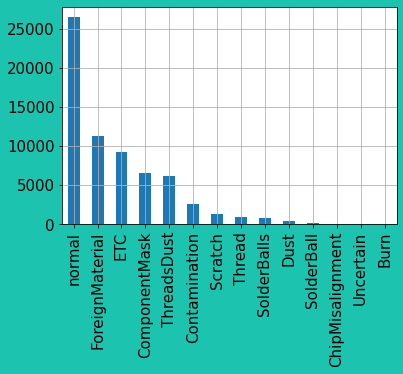

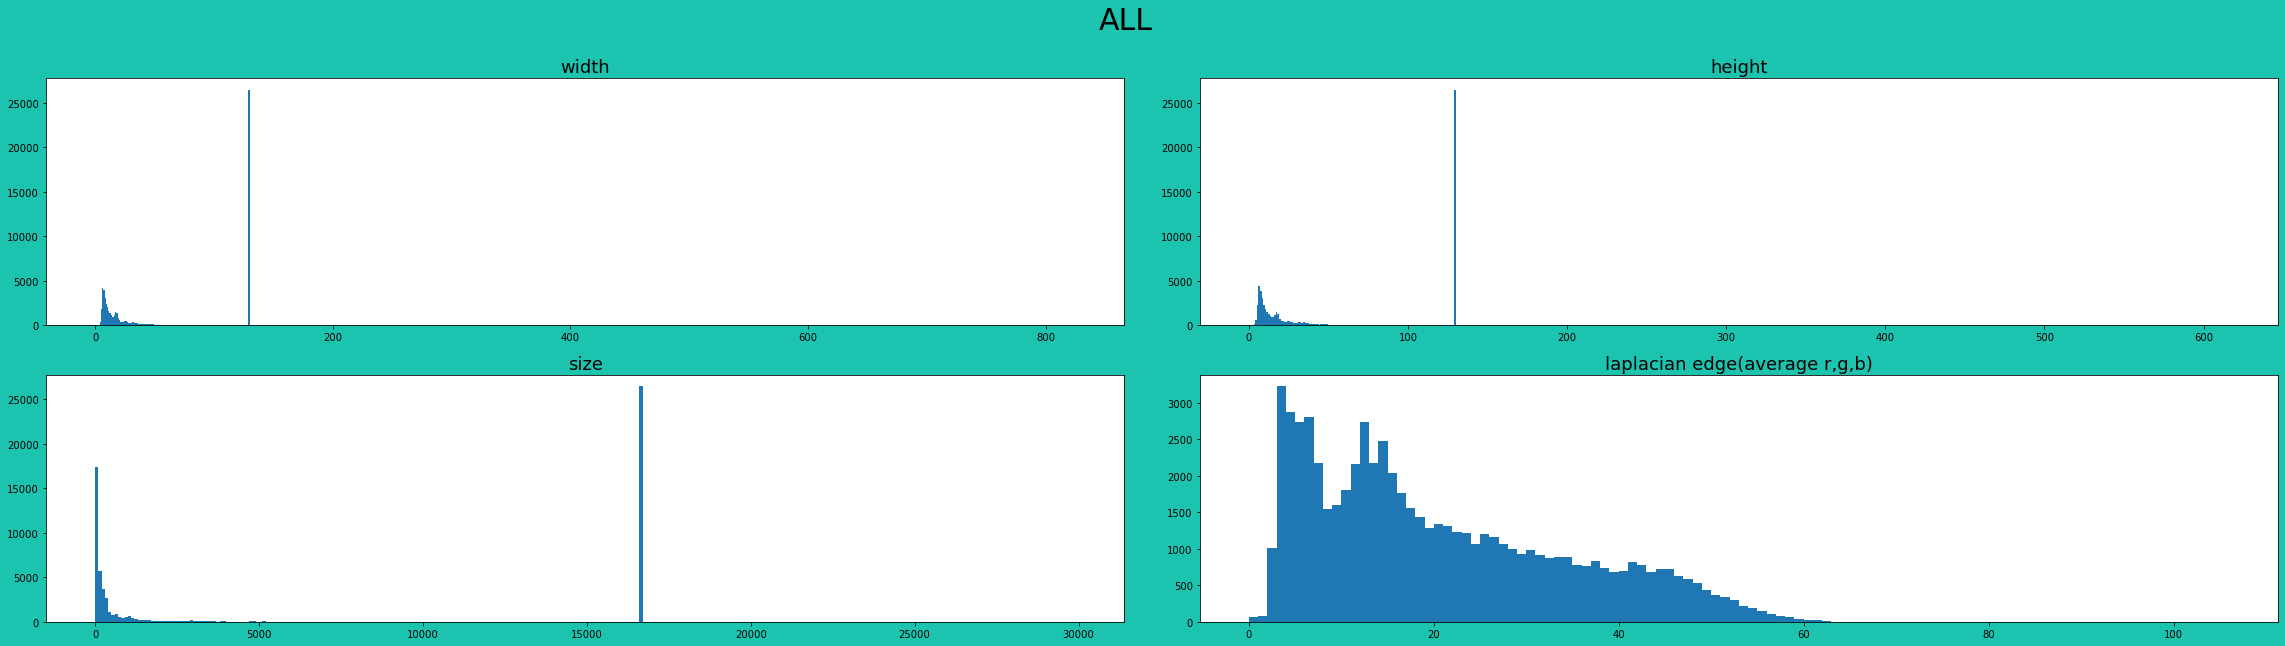

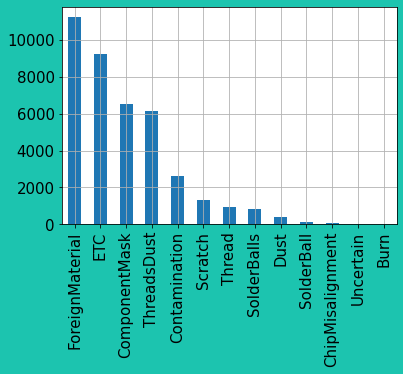

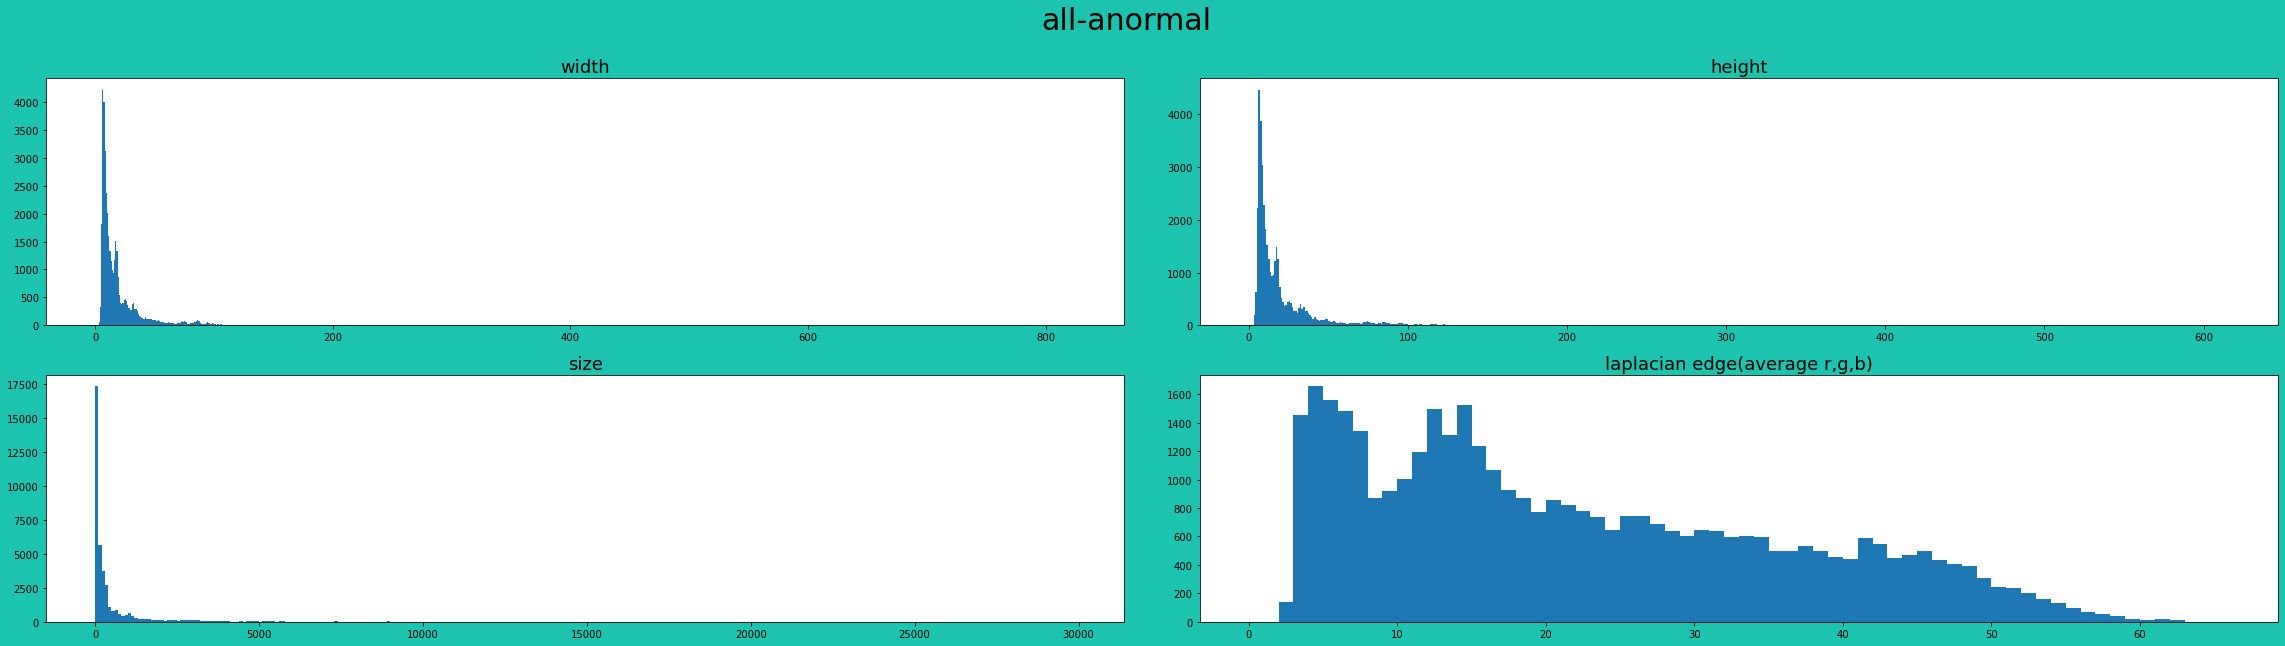

In [14]:
anormal_df = get_anomaly_data_frame(analysis_database)

count_and_plot_bar(analysis_database)
draw_all_kind_of_histogram(analysis_database, 'all-datasets')    

count_and_plot_bar(anormal_df)
draw_all_kind_of_histogram(anormal_df, 'all-anormal')    

Scratch


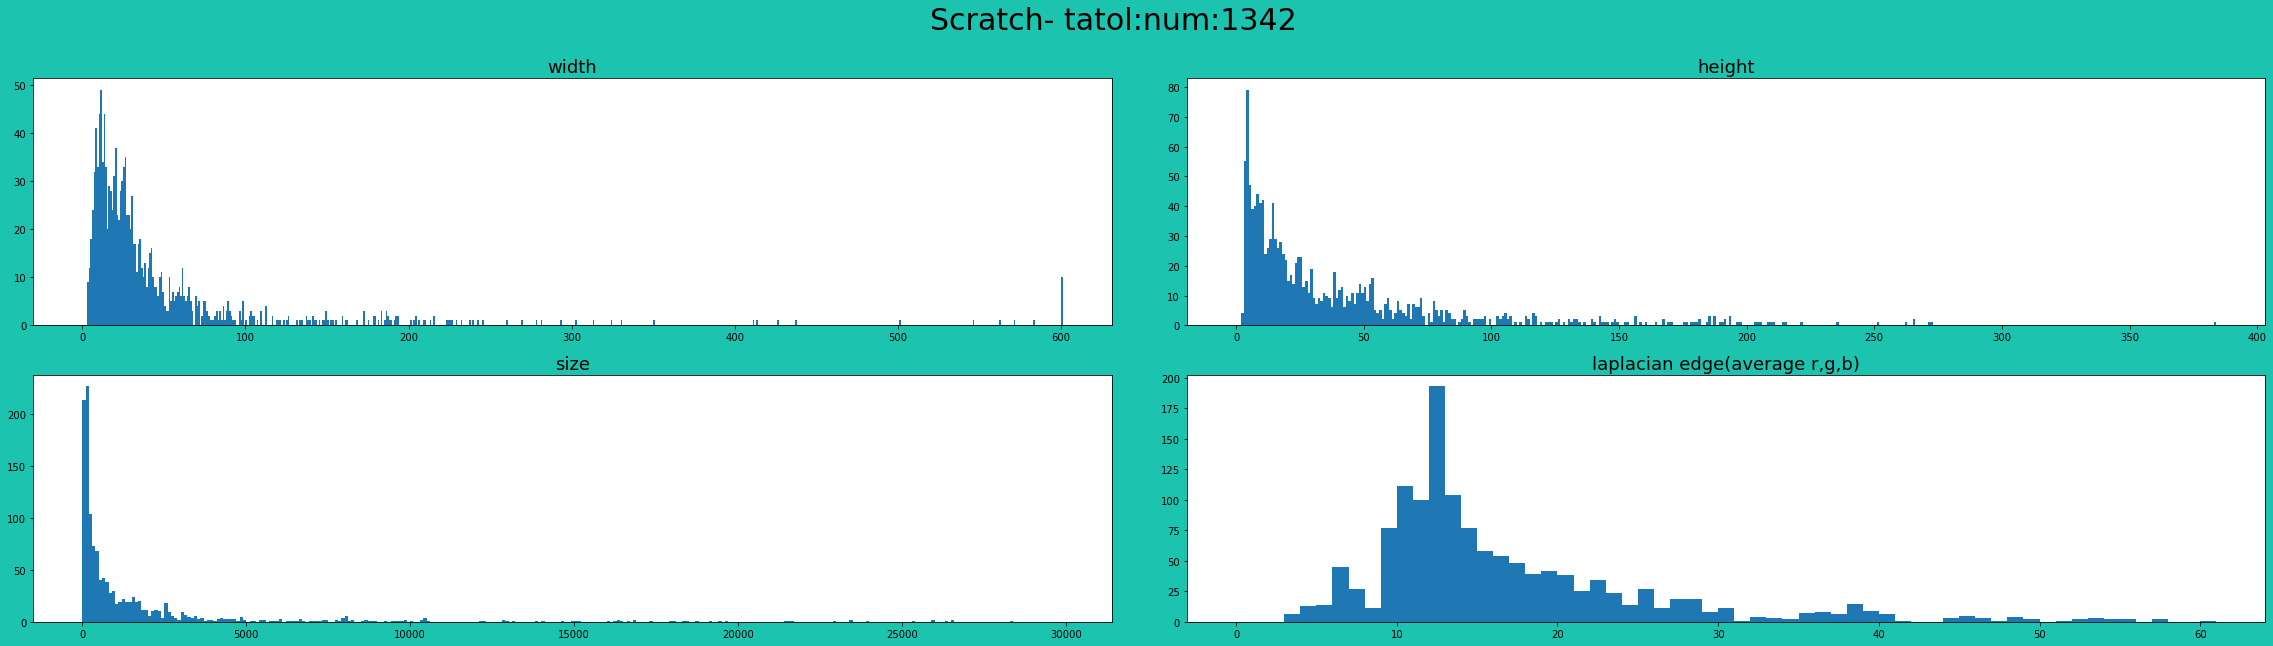

Dust


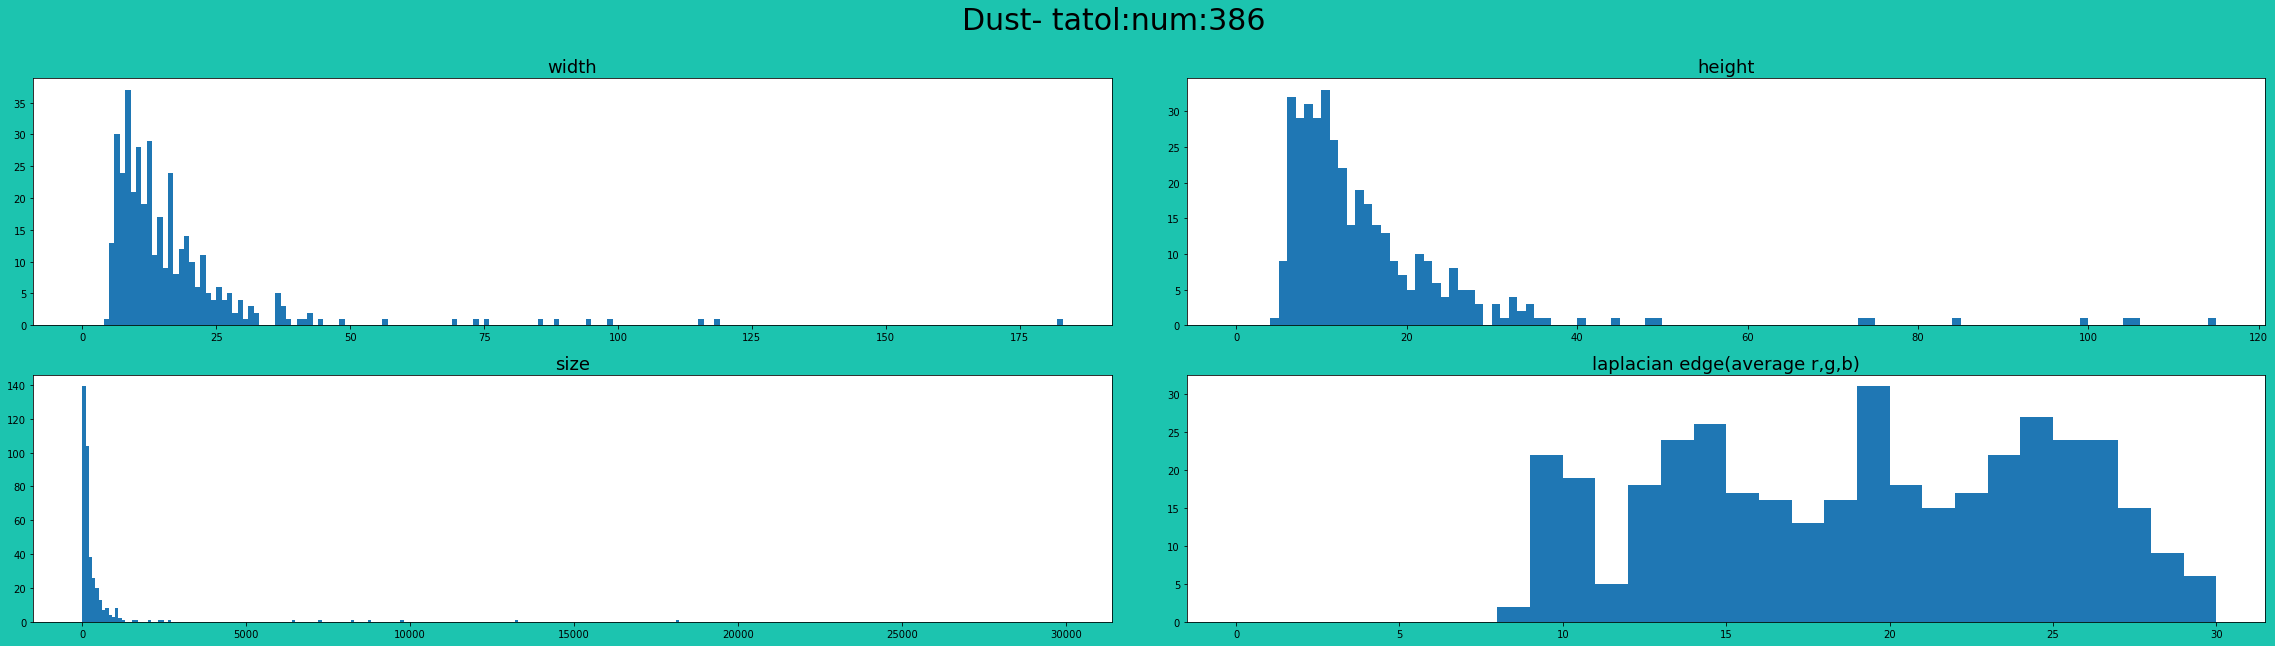

Thread


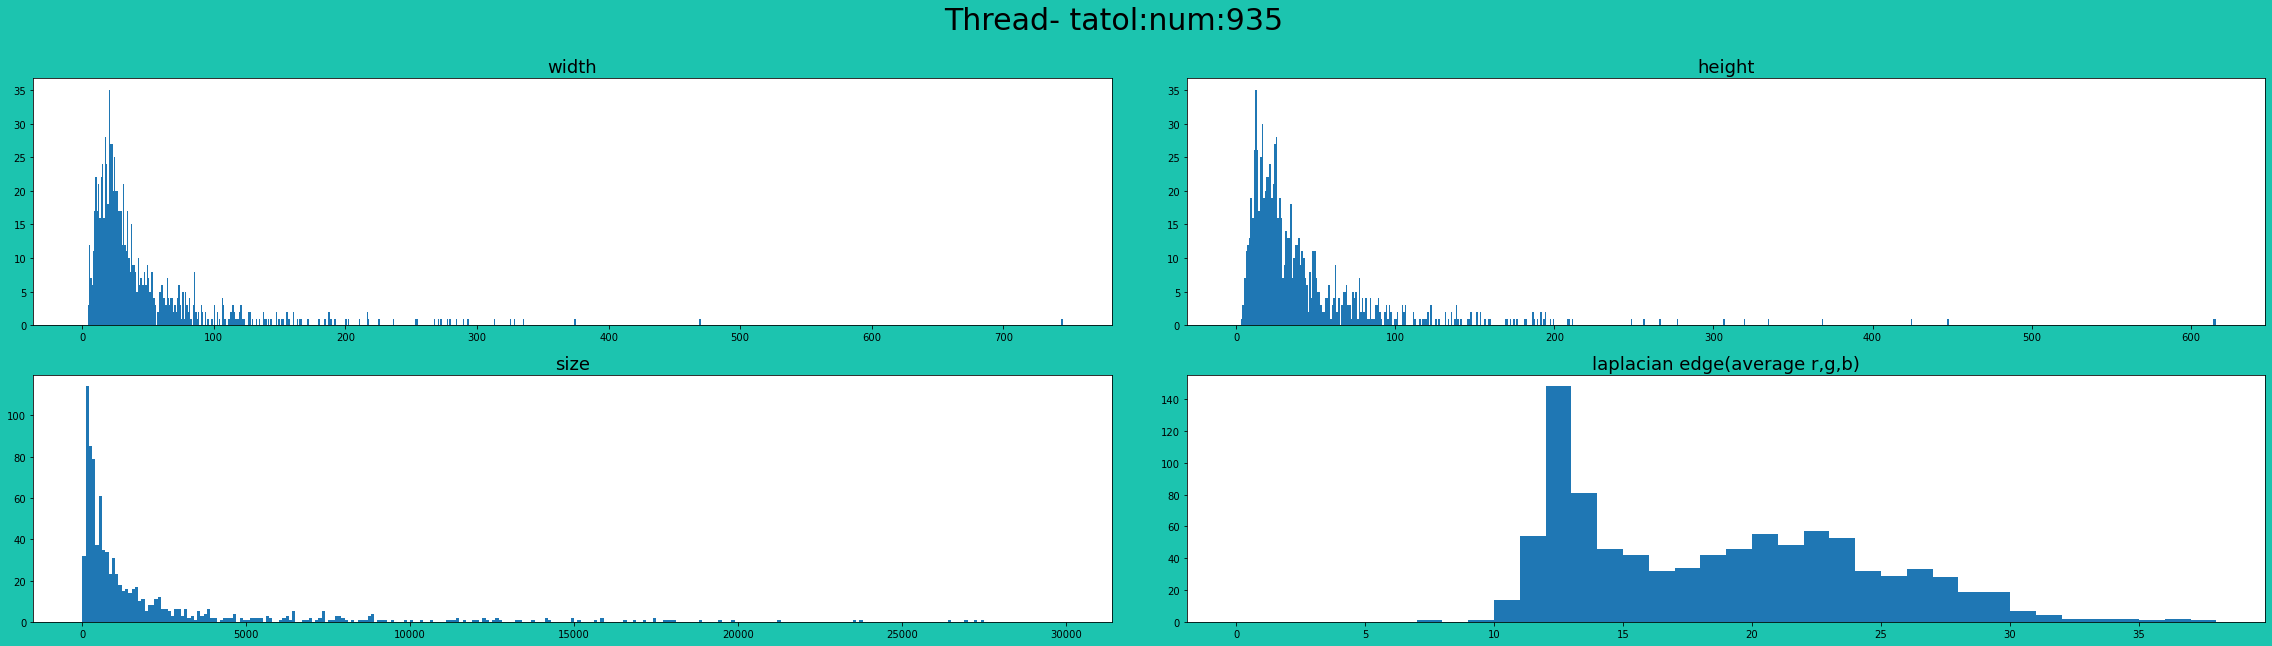

ForeignMaterial


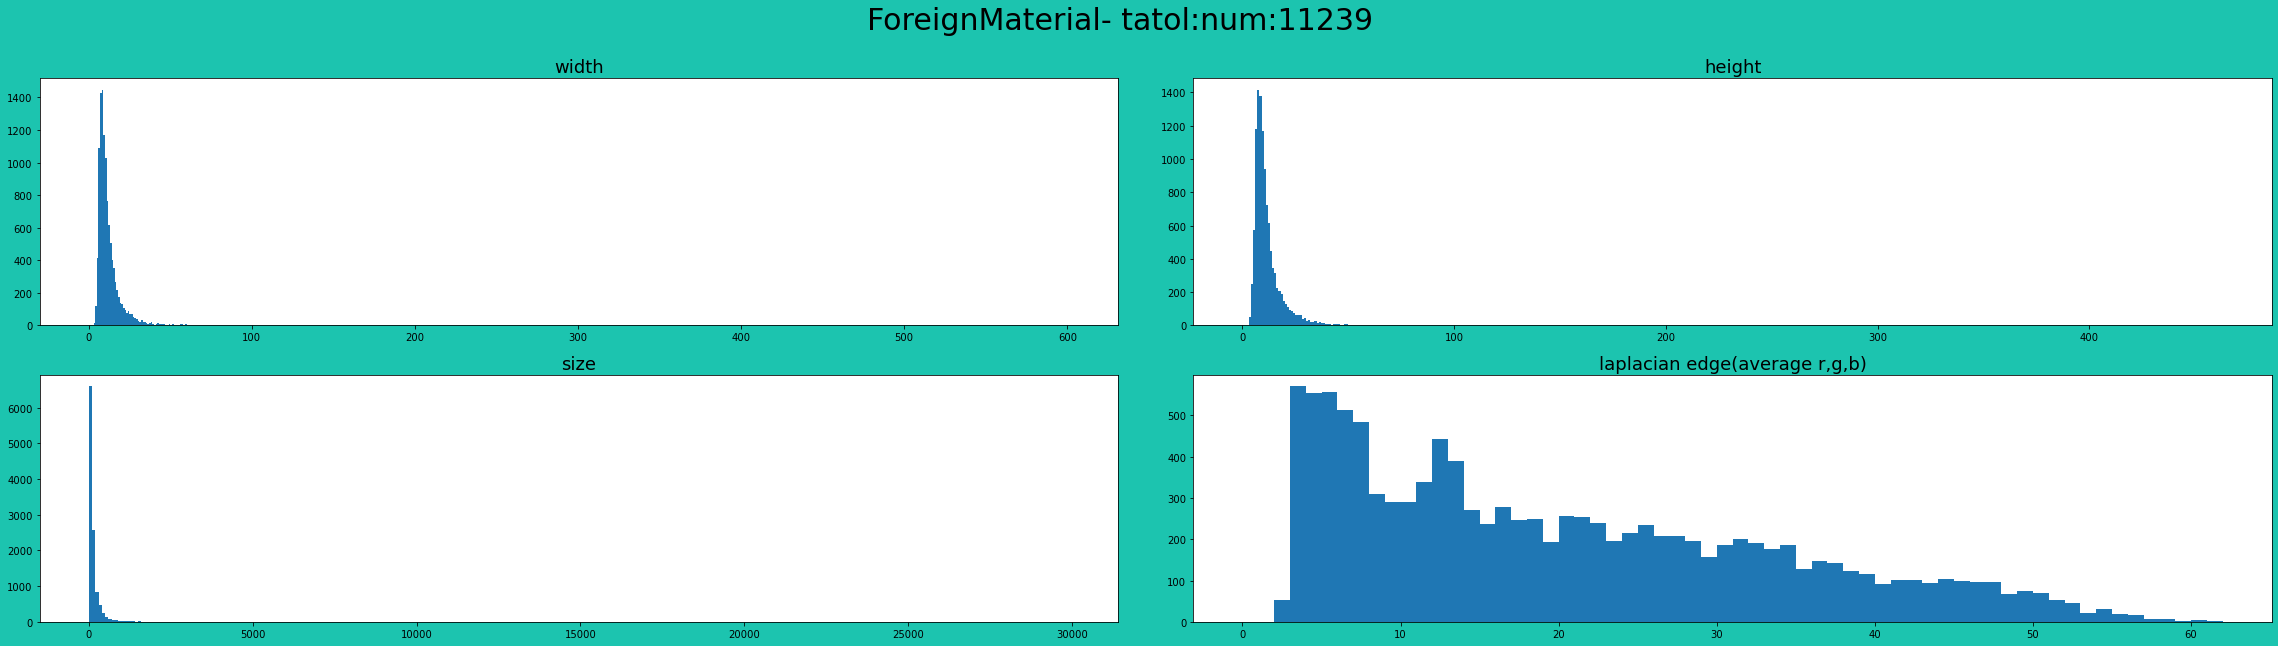

Contamination


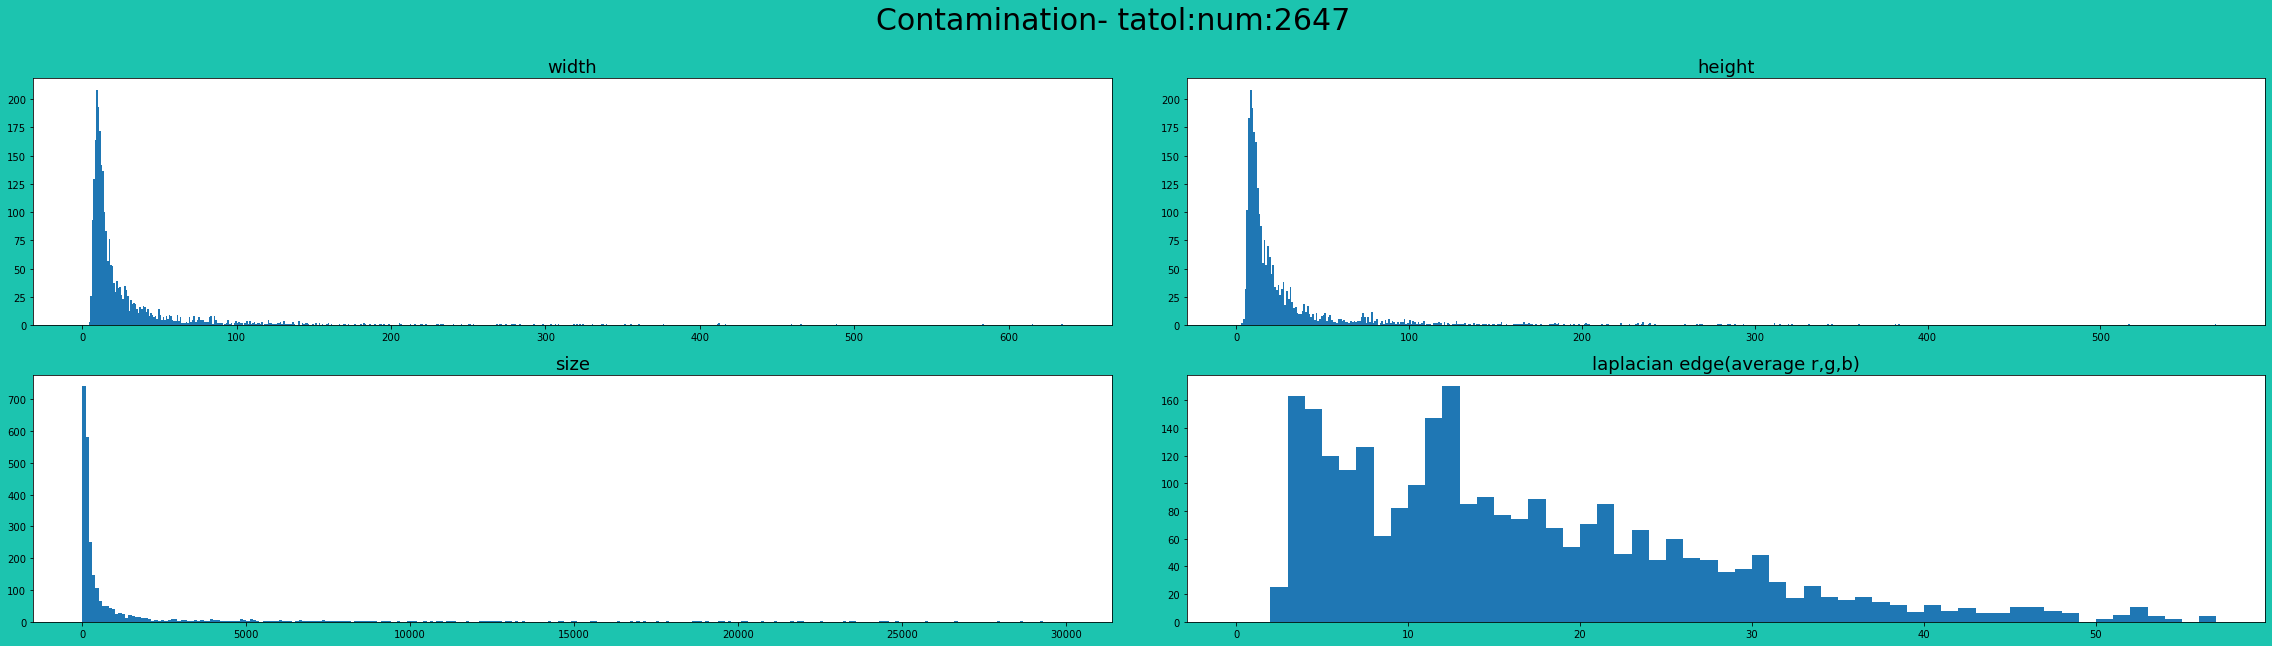

SolderBall


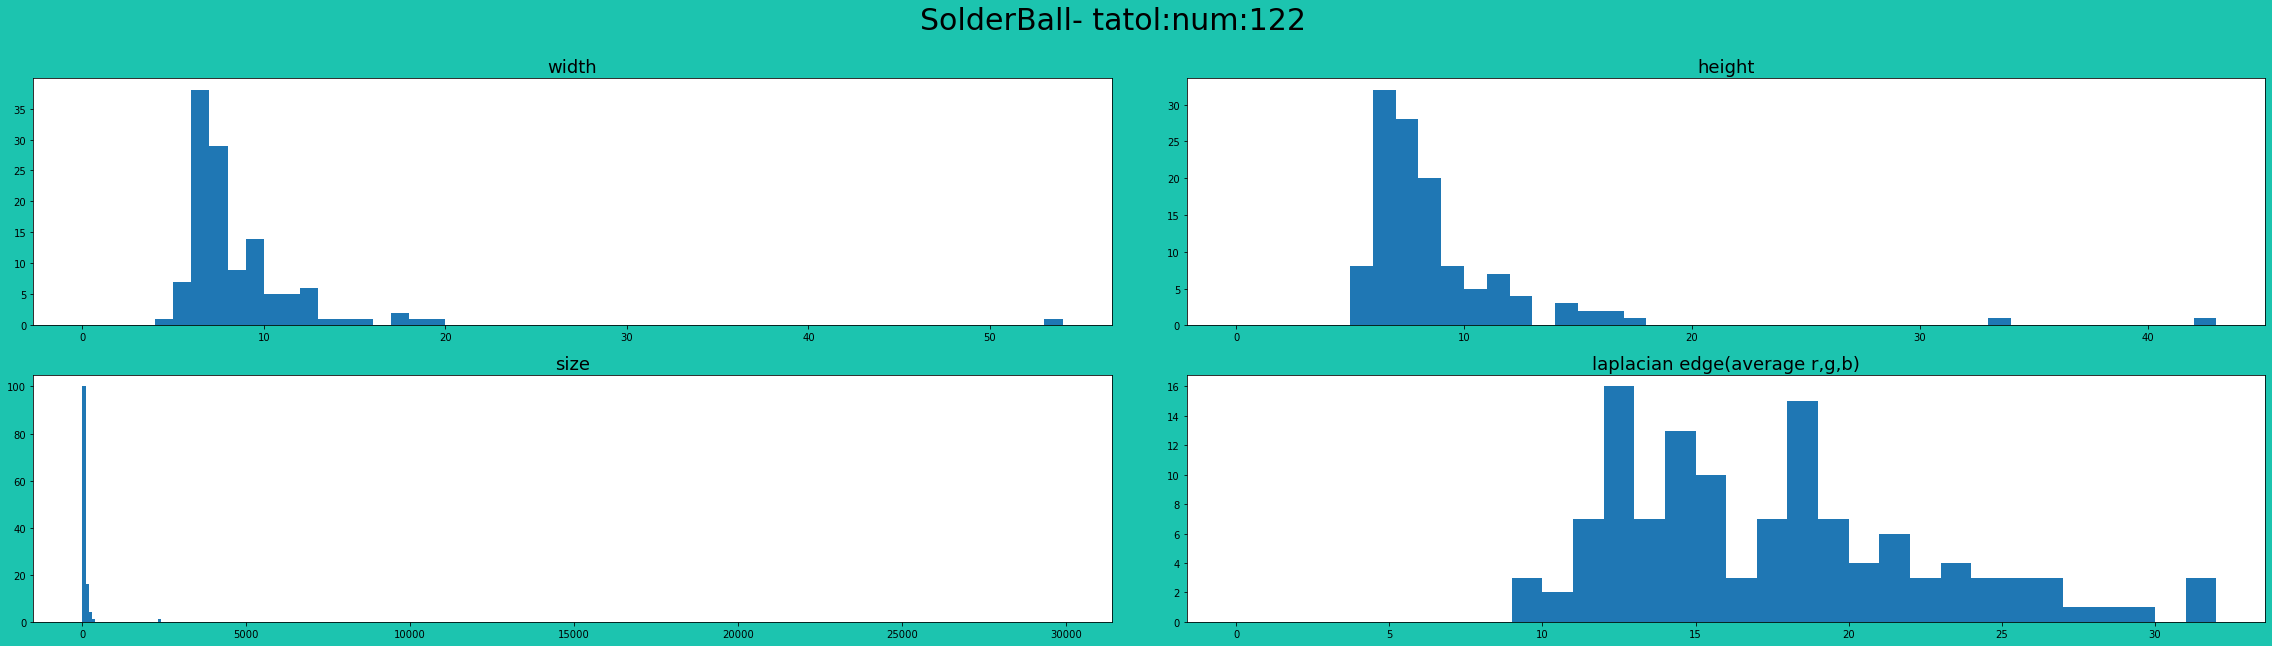

ChipMisalignment


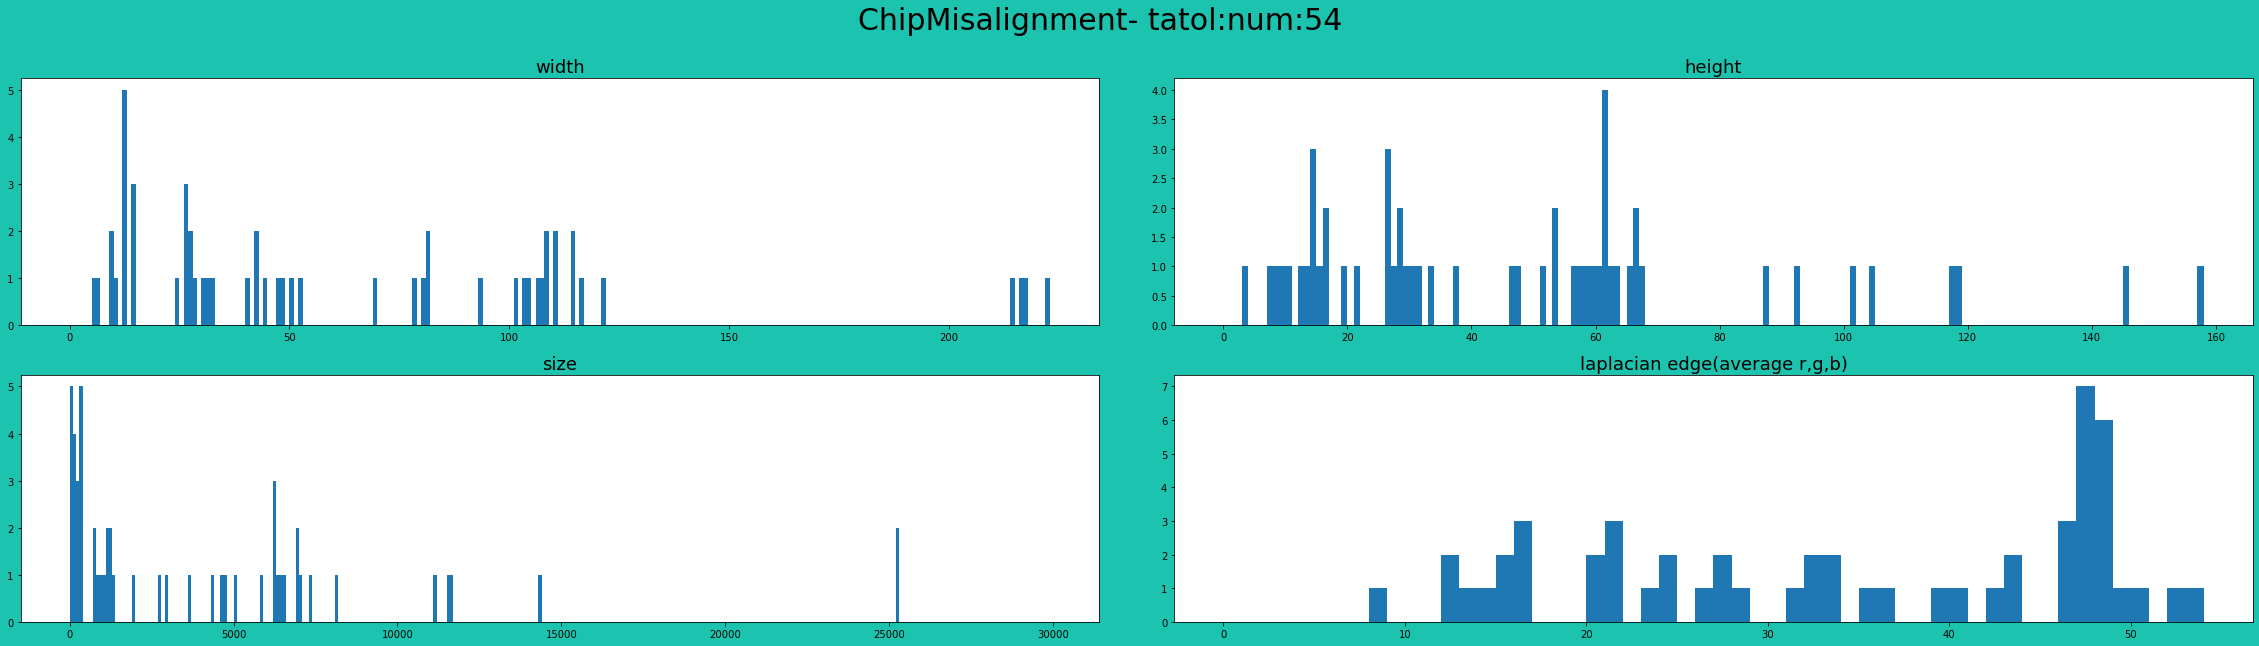

Burn


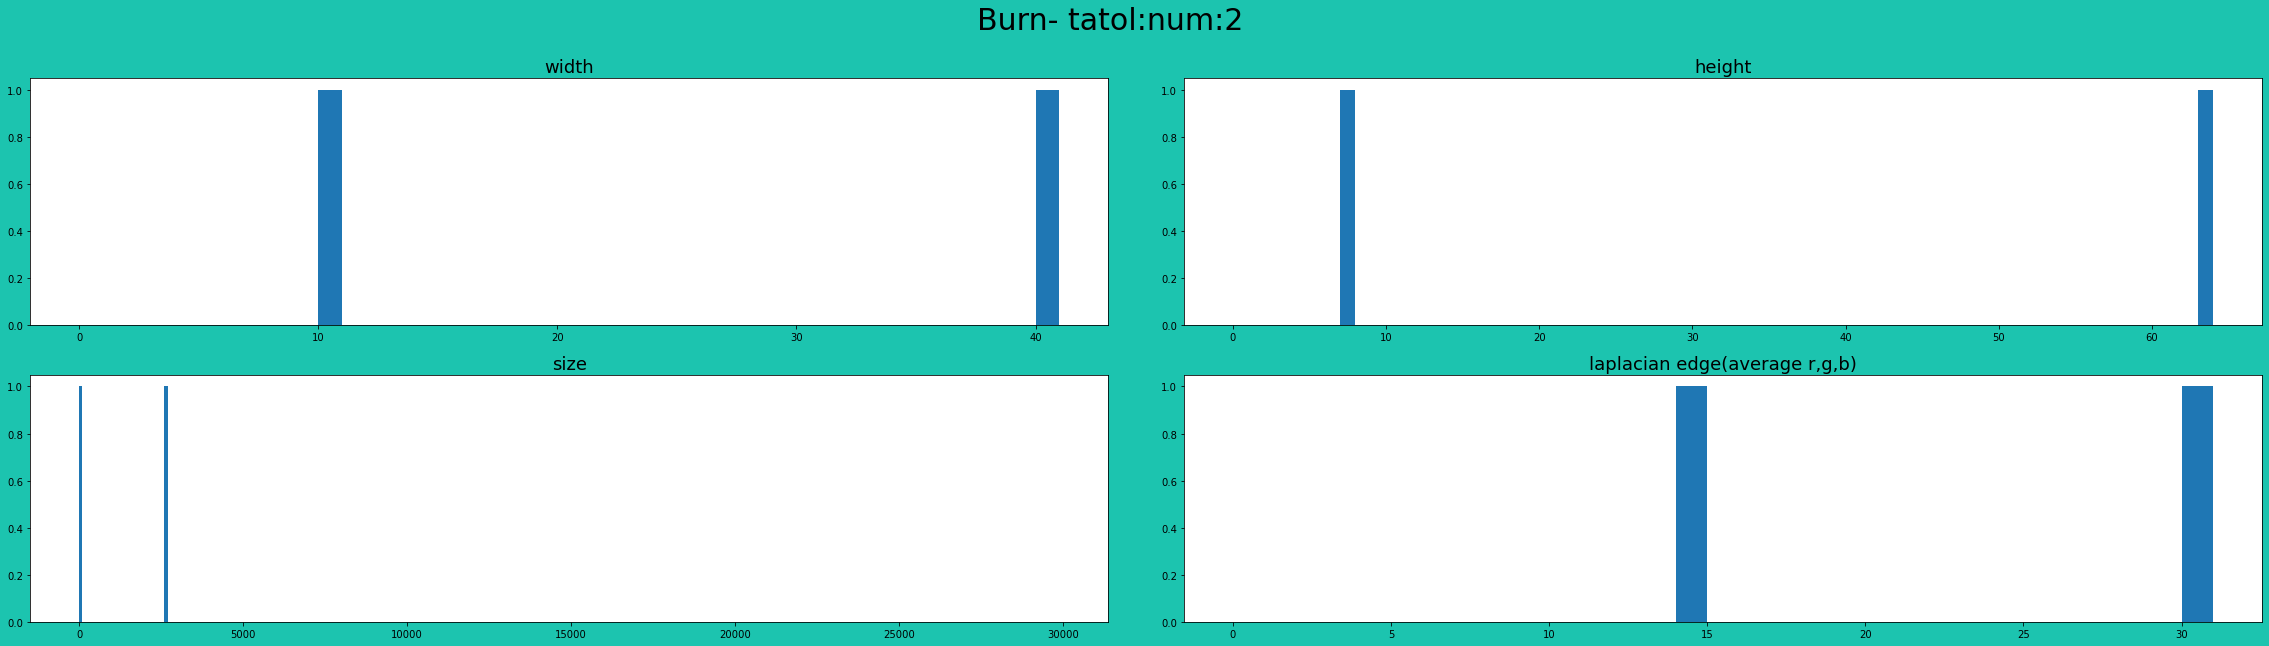

Uncertain


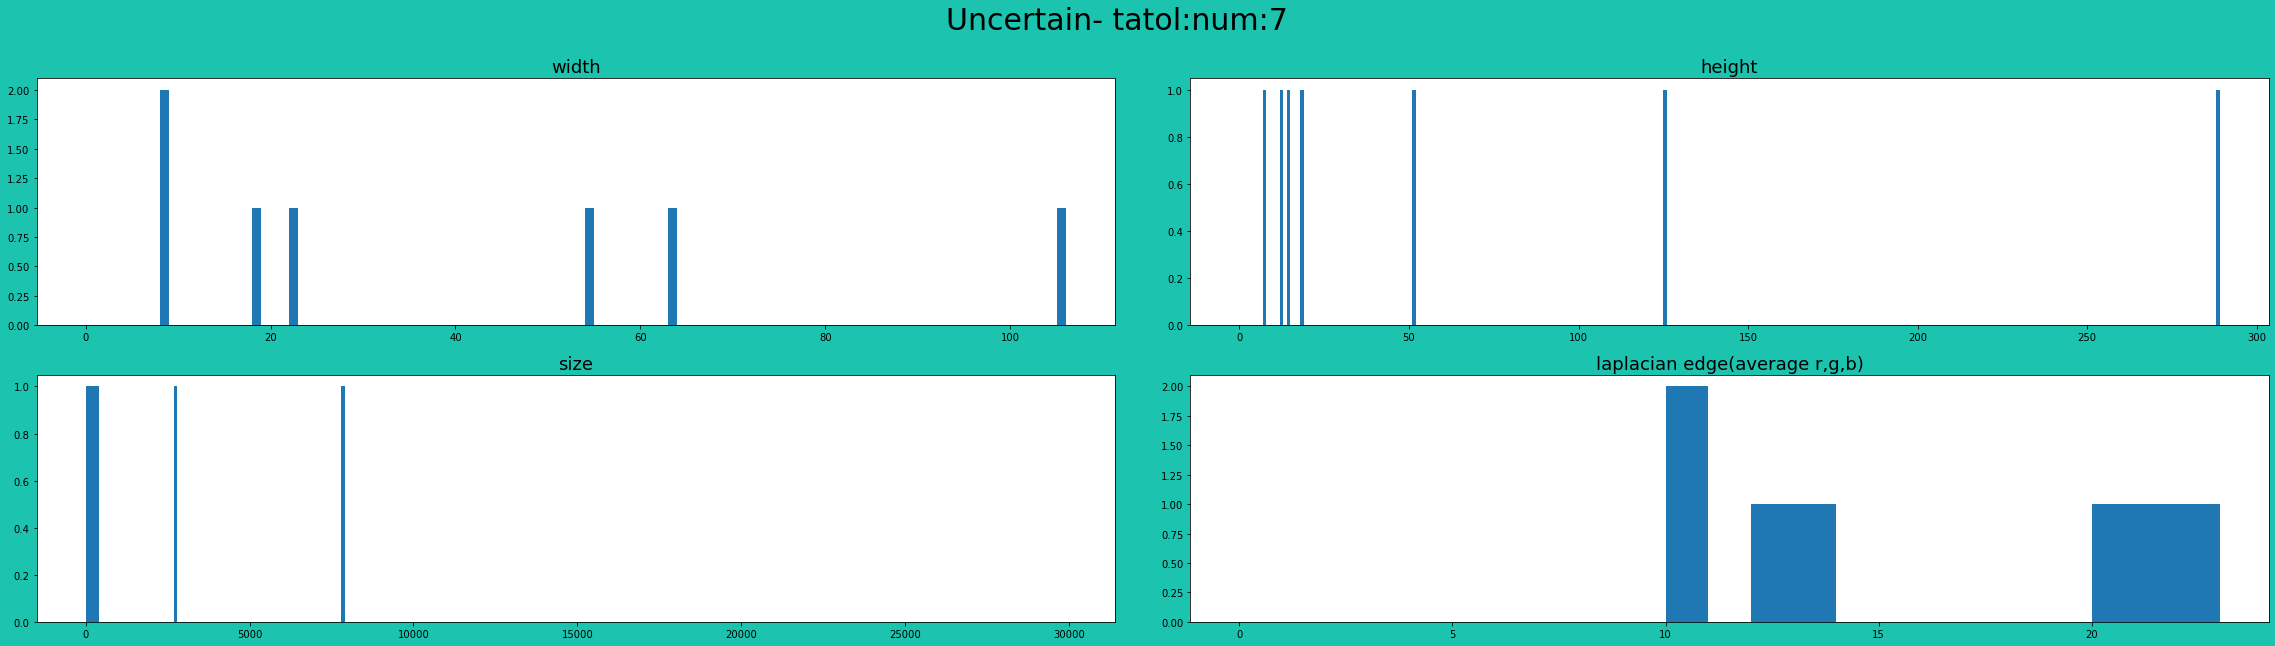

normal


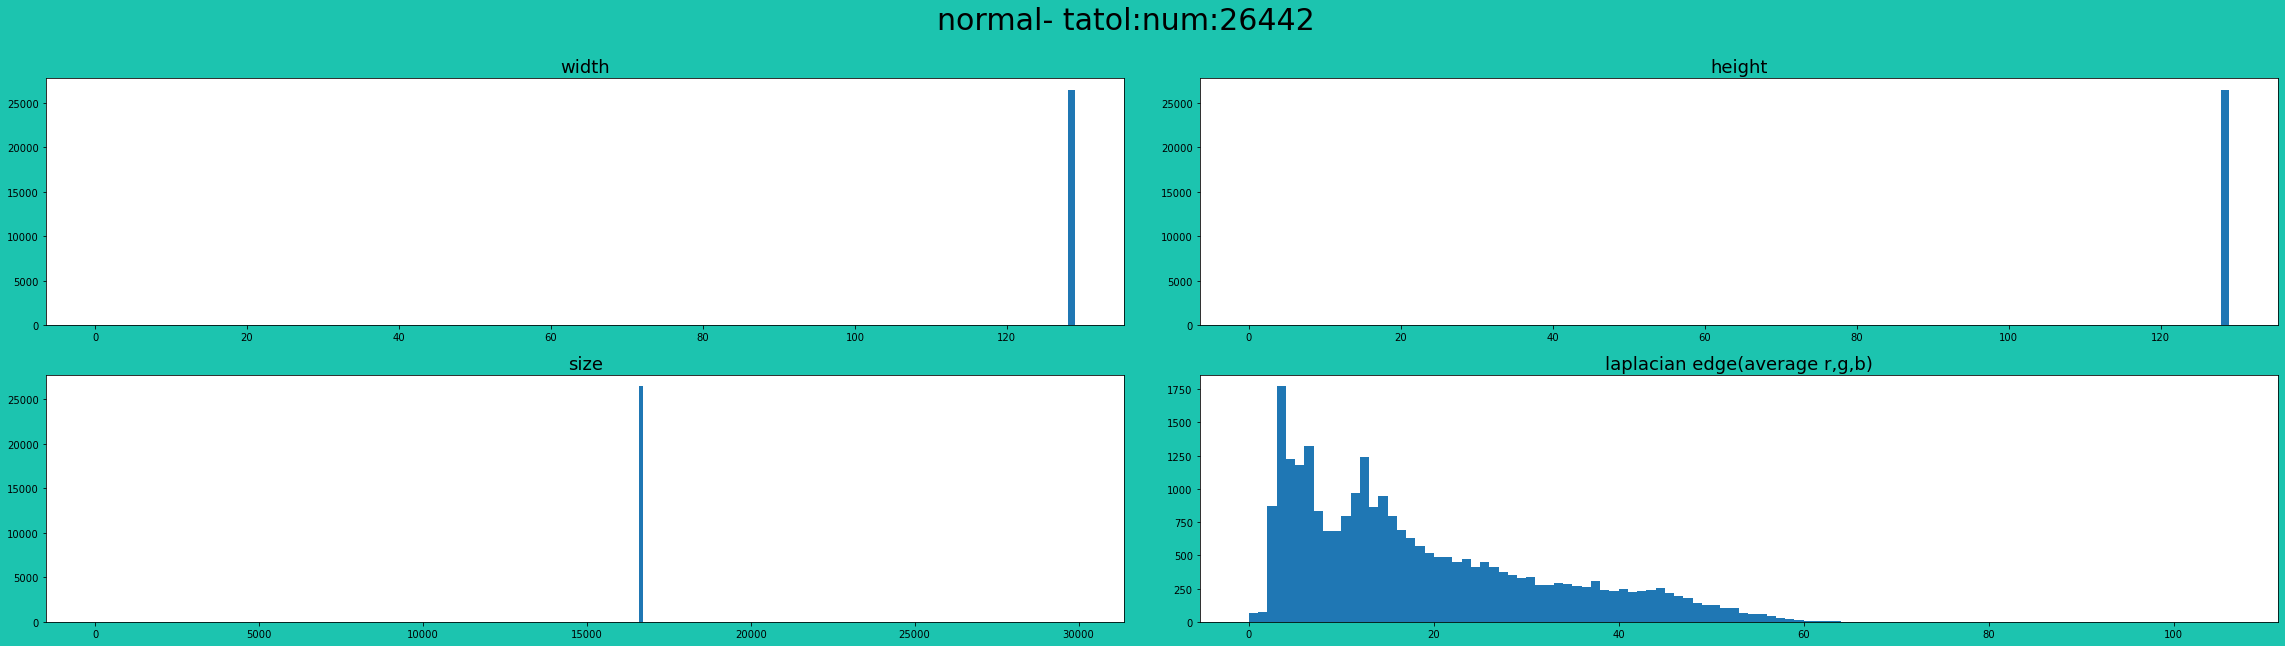

ETC


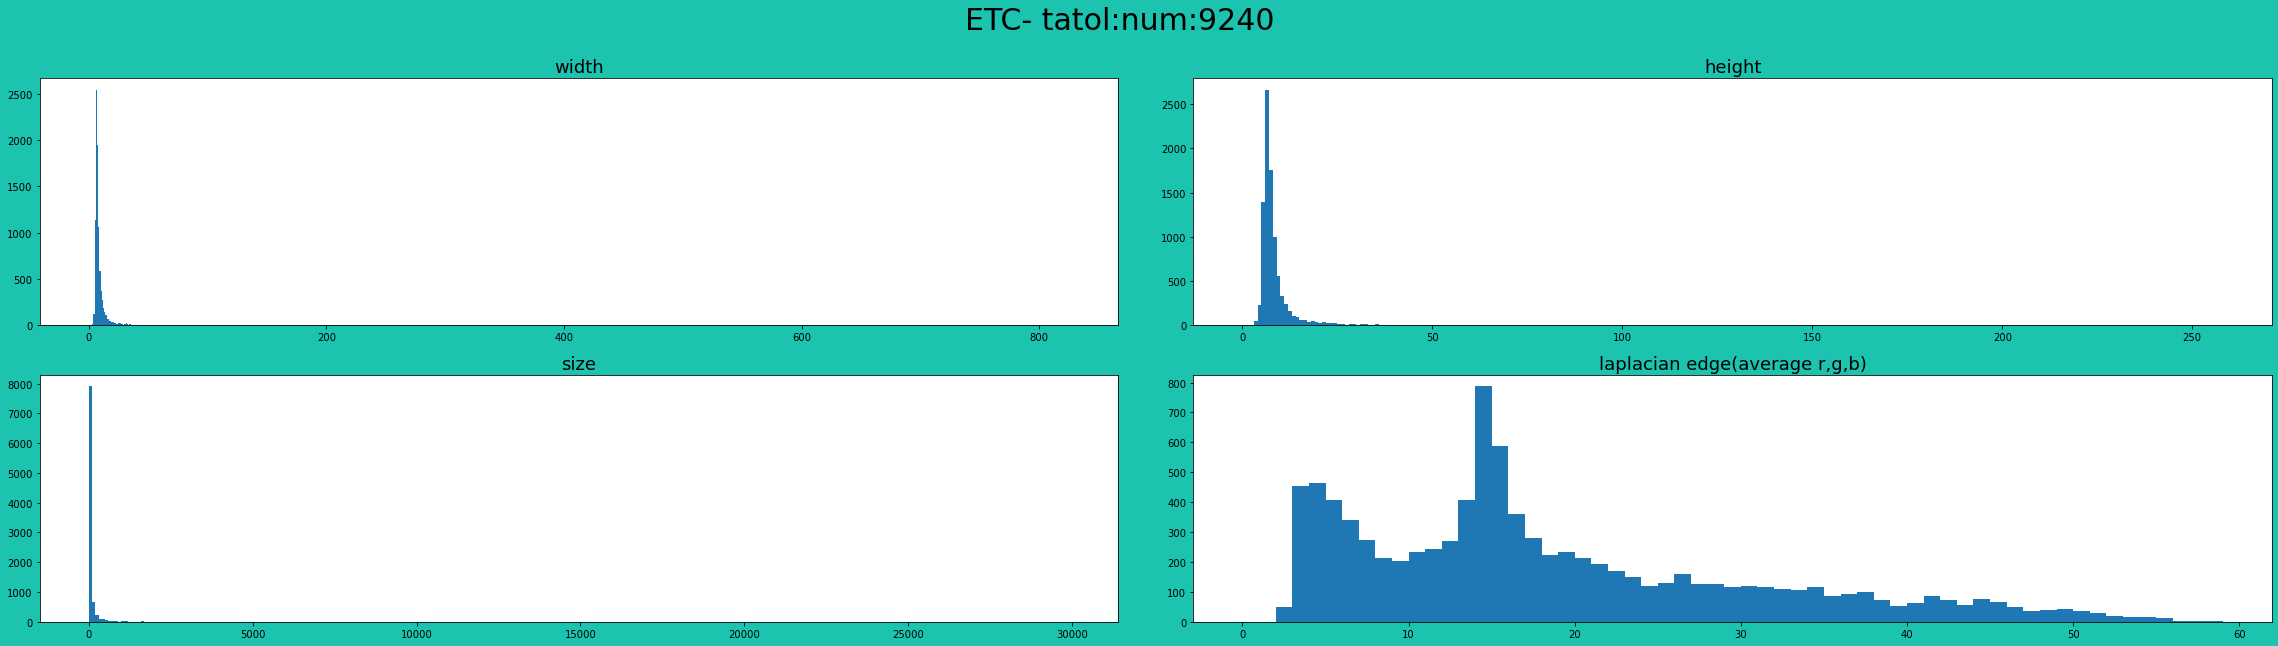

ThreadsDust


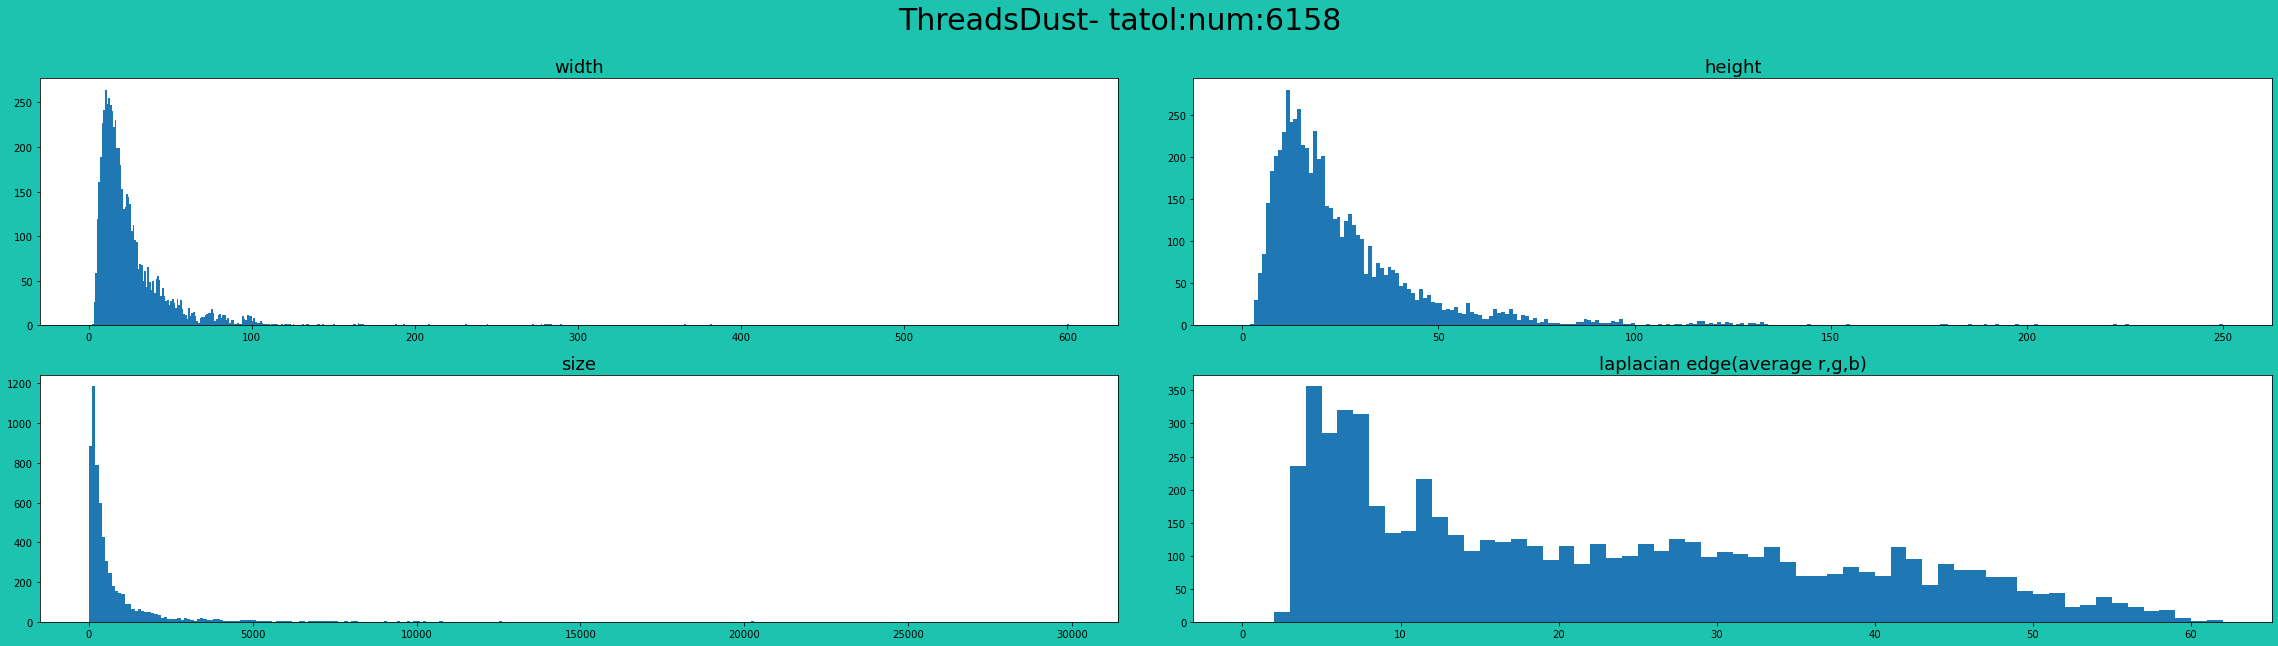

SolderBalls


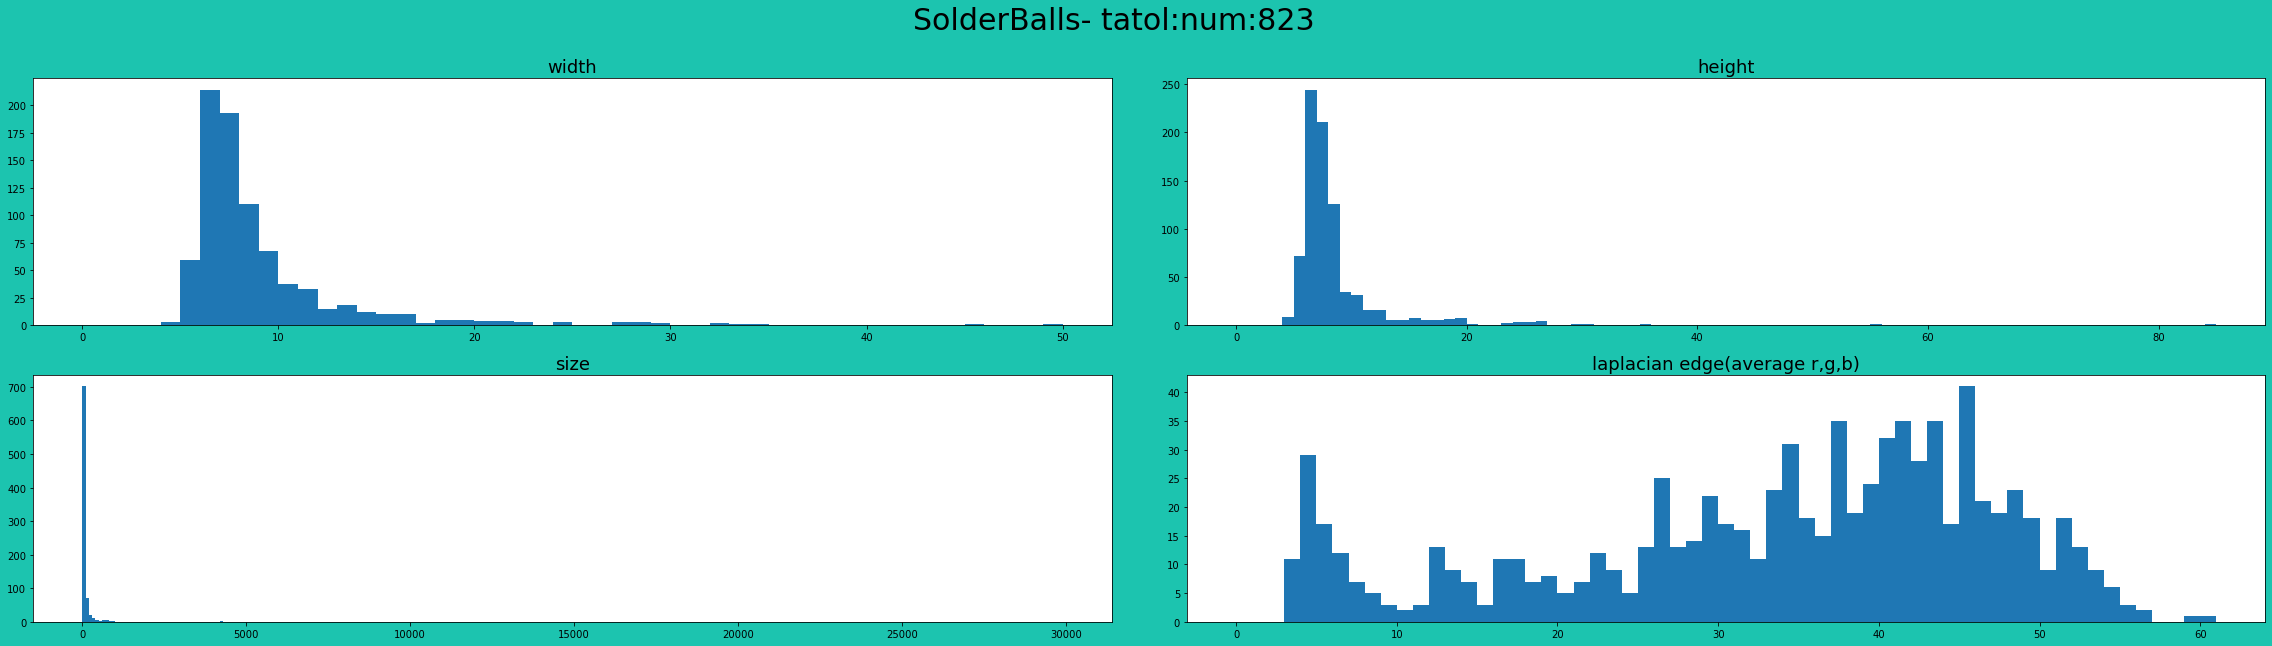

ComponentMask


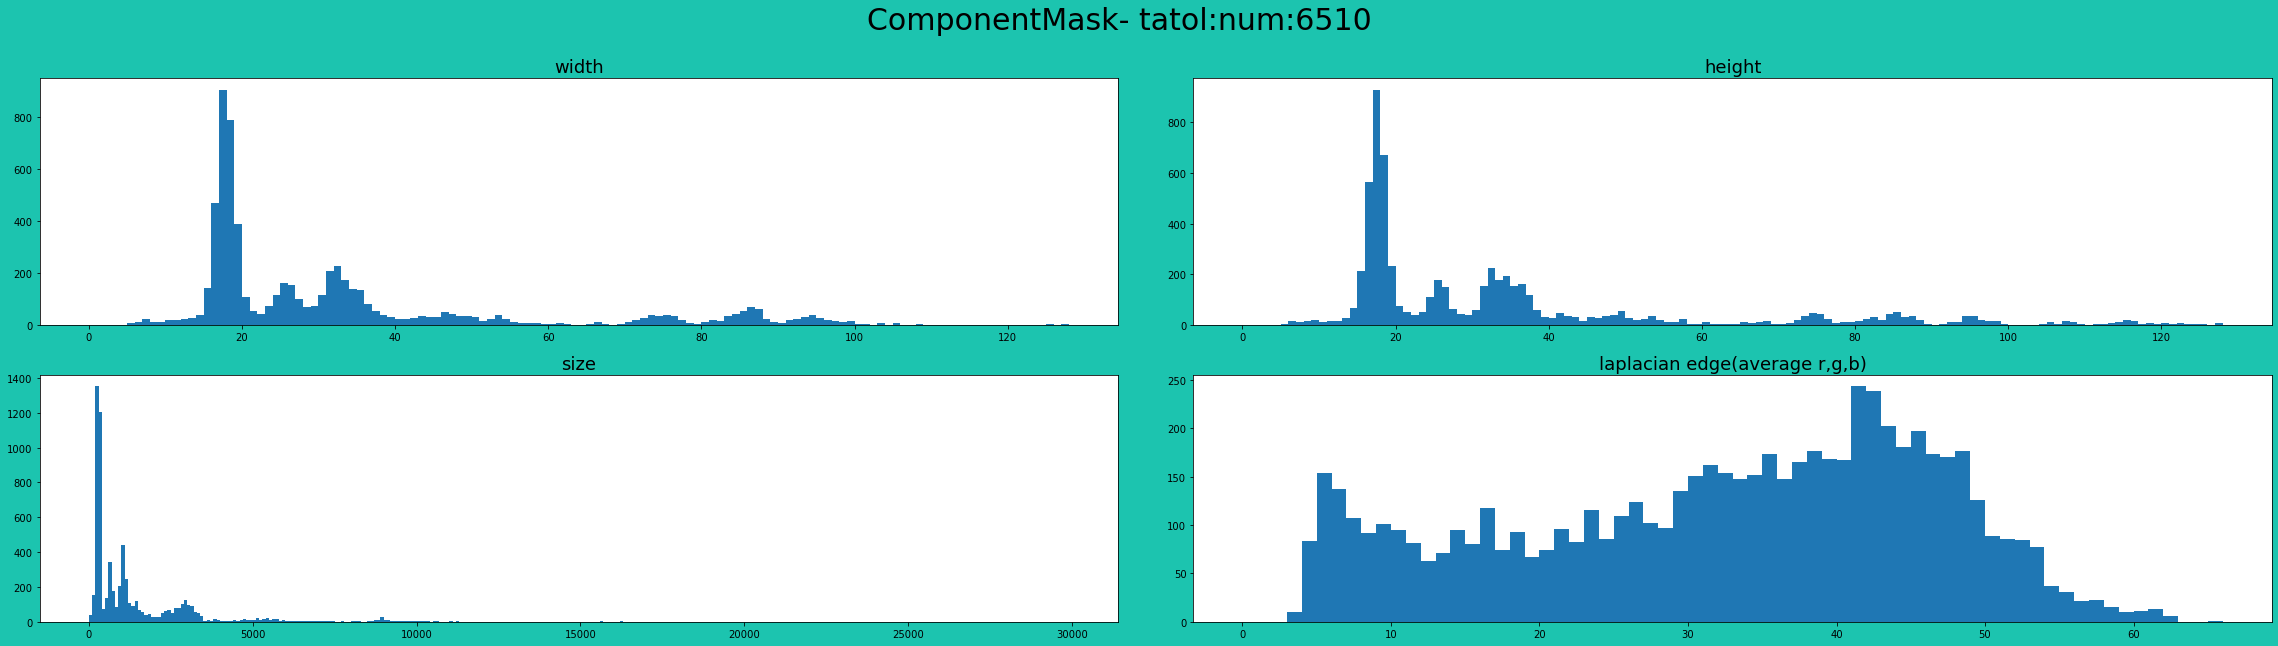

In [15]:
### main call 
DataFrameDict = split_data_frame(analysis_database)

for key in DataFrameDict.keys():
    print(key)
    draw_all_kind_of_histogram(DataFrameDict[key], key + '- tatol:num:'+str(len(DataFrameDict[key]))) 

